In [1]:
import numpy as np
import itertools

# ---- Synthetic Data Generation ----
def generate_synthetic_data(d, N_train, N_test):
    # No fixed seed (non-deterministic)
    theta_actual = np.random.randn(d)
    X_train = np.random.randn(N_train, d)
    y_train = X_train @ theta_actual + np.random.randn(N_train)
    X_test = np.random.randn(N_test, d)
    # y_test is not used for our loss metric; loss is computed on parameter error
    return theta_actual, X_train, y_train, X_test

# ---- Ridge Regression Estimator ----
def ridge_regression_estimator(X, y, indices, lambda_ridge=1.0):
    X_S = X[list(indices), :]
    y_S = y[list(indices)]
    A = X_S.T @ X_S + lambda_ridge * np.eye(X_S.shape[1])
    theta_hat = np.linalg.inv(A) @ (X_S.T @ y_S)
    return theta_hat

def evaluate_loss(X_test, theta_actual, theta_hat):
    errors = np.abs(X_test @ (theta_actual - theta_hat))
    return np.mean(errors)

# ---- Brute Force Optimal Subset (Exhaustive Search) ----
def brute_force_optimal_subset(X_train, y_train, X_test, theta_actual, K, lambda_ridge):
    best_loss = np.inf
    best_subset = None
    for subset in itertools.combinations(range(X_train.shape[0]), K):
        theta_hat = ridge_regression_estimator(X_train, y_train, subset, lambda_ridge=lambda_ridge)
        loss = evaluate_loss(X_test, theta_actual, theta_hat)
        if loss < best_loss:
            best_loss = loss
            best_subset = subset
    return best_subset, best_loss

# ---- DPP-based (CEIL) Method ----
def build_dpp_kernel(demo_embeds, test_embed, lambda_dpp=1.0, scale_factor=1.0):
    """
    Constructs the conditional DPP kernel matrix L' for numerical data.
    Here, r[i] = dot(x_i, test_embed), and we use:
      Lprime[i,j] = exp(r[i]*lambda_dpp/2) * (demo_embeds @ demo_embeds.T)[i,j] * exp(r[j]*lambda_dpp/2)
    """
    n = len(demo_embeds)
    r = np.einsum("ij,j->i", demo_embeds, test_embed)
    sim_mat = demo_embeds @ demo_embeds.T
    Lprime = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            Lprime[i, j] = np.exp(r[i]/(2*lambda_dpp)) * sim_mat[i, j] * np.exp(r[j]/(2*lambda_dpp))
    return Lprime

def dpp_map_inference(Lprime, k_select):
    n = Lprime.shape[0]
    selected = []
    current_logdet = 0.0
    def submatrix_logdet(indices):
        if len(indices)==0:
            return 0.0
        subm = Lprime[np.ix_(indices, indices)]
        return np.linalg.slogdet(subm)[1]
    candidates = set(range(n))
    for _ in range(k_select):
        best_gain = -1e9
        best_item = None
        for i in candidates:
            new_set = selected + [i]
            gain = submatrix_logdet(new_set) - current_logdet
            if gain > best_gain:
                best_gain = gain
                best_item = i
        selected.append(best_item)
        candidates.remove(best_item)
        current_logdet += best_gain
    return selected

# ---- Submodular Method with Log Term ----
def submodular_diverse_select(demo_embeds, test_embed, k, lambd):
    n = demo_embeds.shape[0]
    d = demo_embeds.shape[1]
    selected = []
    V_S = lambd * np.eye(d)
    candidate_indices = set(range(n))
    for _ in range(k):
        invV_S = np.linalg.inv(V_S)
        best_val = -1e9
        best_idx = None
        for i in candidate_indices:
            x = demo_embeds[i]
            num = (test_embed @ invV_S @ x)**2
            denom = 1.0 + (x @ invV_S @ x)
            score = num / denom + lambd * np.log(denom)
            if score > best_val:
                best_val = score
                best_idx = i
        selected.append(best_idx)
        x_sel = demo_embeds[best_idx]
        V_S = V_S + np.outer(x_sel, x_sel)
        candidate_indices.remove(best_idx)
    return selected

# ---- Submodular Method without Log Term ----
def submodular_diverse_select_no_log(demo_embeds, test_embed, k, lambd):
    n = demo_embeds.shape[0]
    d = demo_embeds.shape[1]
    selected = []
    V_S = lambd * np.eye(d)
    candidate_indices = set(range(n))
    for _ in range(k):
        invV_S = np.linalg.inv(V_S)
        best_val = -1e9
        best_idx = None
        for i in candidate_indices:
            x = demo_embeds[i]
            num = (test_embed @ invV_S @ x)**2
            denom = 1.0 + (x @ invV_S @ x)
            score = num / denom + lambd * (1.0 + (x @ invV_S @ x))
            if score > best_val:
                best_val = score
                best_idx = i
        selected.append(best_idx)
        x_sel = demo_embeds[best_idx]
        V_S = V_S + np.outer(x_sel, x_sel)
        candidate_indices.remove(best_idx)
    return selected

# ---- Main Experiment Function ----
def experiment(d, N_train, N_test, K, lambda_ridge, lambda_dpp):
    # Generate synthetic data (non-deterministic, no fixed seed)
    theta_actual, X_train, y_train, X_test = generate_synthetic_data(d, N_train, N_test)

    # Brute-force optimal subset (may be expensive for large N_train)
    print("Brute-force search over all subsets of size", K)
    best_subset, best_loss = brute_force_optimal_subset(X_train, y_train, X_test, theta_actual, K, lambda_ridge)

    # Use training inputs as "embeddings"
    demo_embeddings_linear = X_train

    # Method A: CEIL's DPP MAP Inference
    Lprime = build_dpp_kernel(demo_embeddings_linear, X_test[0], lambda_dpp=lambda_dpp)
    indices_dpp = dpp_map_inference(Lprime, k_select=K)
    theta_hat_dpp = ridge_regression_estimator(X_train, y_train, indices_dpp, lambda_ridge)
    loss_dpp = evaluate_loss(X_test, theta_actual, theta_hat_dpp)

    # Method B: Submodular Method (with log)
    indices_submod = submodular_diverse_select(demo_embeddings_linear, X_test[0], k=K, lambd=lambda_dpp)
    theta_hat_submod = ridge_regression_estimator(X_train, y_train, indices_submod, lambda_ridge)
    loss_submod = evaluate_loss(X_test, theta_actual, theta_hat_submod)

    # Method C: Submodular Method (no log)
    indices_submod_nolog = submodular_diverse_select_no_log(demo_embeddings_linear, X_test[0], k=K, lambd=lambda_dpp)
    theta_hat_submod_nolog = ridge_regression_estimator(X_train, y_train, indices_submod_nolog, lambda_ridge)
    loss_submod_nolog = evaluate_loss(X_test, theta_actual, theta_hat_submod_nolog)

    return {
        "brute_force": {"indices": best_subset, "loss": best_loss},
        "dpp": {"indices": indices_dpp, "loss": loss_dpp},
        "submodular_log": {"indices": indices_submod, "loss": loss_submod},
        "submodular_nolog": {"indices": indices_submod_nolog, "loss": loss_submod_nolog}
    }

In [2]:
# Set hyperparameters (you can change these as needed)
d = 5
N_train = 50
N_test = 50
K = 5
lambda_ridge = 10.0
lambda_dpp = 10.0

results = experiment(d, N_train, N_test, K, lambda_ridge, lambda_dpp)

print("------------------------------------------------------------")
print("Brute Force Optimal Subset:")
print("  Selected indices:", results["brute_force"]["indices"])
print("  Loss:", results["brute_force"]["loss"])
print("------------------------------------------------------------")
print("CEIL's DPP Method:")
print("  Selected indices:", results["dpp"]["indices"])
print("  Loss:", results["dpp"]["loss"])
print("------------------------------------------------------------")
print("Submodular Method (with log):")
print("  Selected indices:", results["submodular_log"]["indices"])
print("  Loss:", results["submodular_log"]["loss"])
print("------------------------------------------------------------")
print("Submodular Method (no log):")
print("  Selected indices:", results["submodular_nolog"]["indices"])
print("  Loss:", results["submodular_nolog"]["loss"])
print("------------------------------------------------------------")


Brute-force search over all subsets of size 5
------------------------------------------------------------
Brute Force Optimal Subset:
  Selected indices: (2, 32, 33, 39, 42)
  Loss: 0.7877902494767269
------------------------------------------------------------
CEIL's DPP Method:
  Selected indices: [30, 47, 22, 37, 33]
  Loss: 1.4286997555213141
------------------------------------------------------------
Submodular Method (with log):
  Selected indices: [30, 22, 47, 33, 37]
  Loss: 1.4286997555213141
------------------------------------------------------------
Submodular Method (no log):
  Selected indices: [30, 22, 47, 33, 37]
  Loss: 1.4286997555213141
------------------------------------------------------------


Varying d:   0%|          | 0/15 [00:00<?, ?it/s]

Brute-force search over all subsets of size 5


Varying d:   7%|▋         | 1/15 [01:59<27:46, 119.06s/it]

Brute-force search over all subsets of size 5


Varying d:  13%|█▎        | 2/15 [04:19<28:27, 131.36s/it]

Brute-force search over all subsets of size 5


Varying d:  20%|██        | 3/15 [07:11<30:02, 150.22s/it]

Brute-force search over all subsets of size 5


Varying d:  27%|██▋       | 4/15 [10:46<32:10, 175.53s/it]

Brute-force search over all subsets of size 5


Varying d:  33%|███▎      | 5/15 [15:15<34:54, 209.41s/it]

Brute-force search over all subsets of size 5


Varying d:  40%|████      | 6/15 [20:50<37:48, 252.06s/it]

Brute-force search over all subsets of size 5


Varying d:  47%|████▋     | 7/15 [27:54<41:07, 308.44s/it]

Brute-force search over all subsets of size 5


Varying d:  53%|█████▎    | 8/15 [36:02<42:38, 365.55s/it]

Brute-force search over all subsets of size 5


Varying d:  60%|██████    | 9/15 [46:15<44:16, 442.82s/it]

Brute-force search over all subsets of size 5


Varying d:  67%|██████▋   | 10/15 [58:16<44:03, 528.72s/it]

Brute-force search over all subsets of size 5


Varying d:  73%|███████▎  | 11/15 [1:13:07<42:38, 639.72s/it]

Brute-force search over all subsets of size 5


Varying d:  80%|████████  | 12/15 [1:30:04<37:43, 754.41s/it]

Brute-force search over all subsets of size 5


Varying d:  87%|████████▋ | 13/15 [1:50:24<29:50, 895.34s/it]

Brute-force search over all subsets of size 5


Varying d:  93%|█████████▎| 14/15 [2:14:03<17:33, 1053.50s/it]

Brute-force search over all subsets of size 5


Varying d: 100%|██████████| 15/15 [2:41:20<00:00, 645.39s/it] 


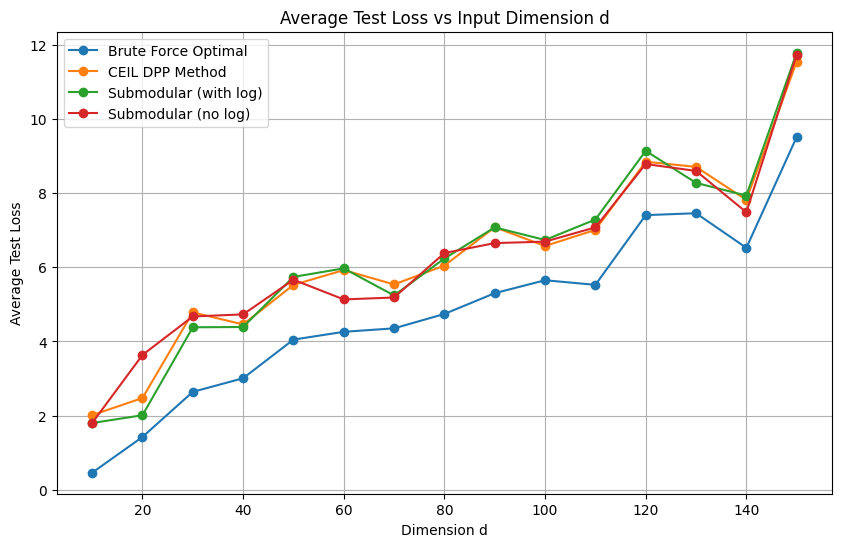

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# Fixed hyperparameters (for the rest of the experiment)
N_train = 50         # number of training points
N_test = 50          # number of test points
K = 5                # subset size
lambda_ridge = 1.0   # regularization parameter for ridge regression
lambda_dpp = 1.0     # hyperparameter used in the DPP/submodular selection methods

# Vary the dimension d from 10 to 150 in steps of 10
d_values = np.arange(10, 160, 10)

# Lists to store the average test losses for each method
loss_brute = []
loss_dpp = []
loss_submod_log = []
loss_submod_nolog = []

for d in tqdm(d_values, desc="Varying d"):
    # Call the experiment function defined in Cell 1/2
    results = experiment(d, N_train, N_test, K, lambda_ridge, lambda_dpp)
    loss_brute.append(results["brute_force"]["loss"])
    loss_dpp.append(results["dpp"]["loss"])
    loss_submod_log.append(results["submodular_log"]["loss"])
    loss_submod_nolog.append(results["submodular_nolog"]["loss"])

# Plot the average test loss vs dimension d for all four methods
plt.figure(figsize=(10, 6))
plt.plot(d_values, loss_brute, marker="o", label="Brute Force Optimal")
plt.plot(d_values, loss_dpp, marker="o", label="CEIL DPP Method")
plt.plot(d_values, loss_submod_log, marker="o", label="Submodular (with log)")
plt.plot(d_values, loss_submod_nolog, marker="o", label="Submodular (no log)")
plt.xlabel("Dimension d")
plt.ylabel("Average Test Loss")
plt.title("Average Test Loss vs Input Dimension d")
plt.legend()
plt.grid(True)
plt.show()

Varying lambda_ridge:   0%|          | 0/20 [00:00<?, ?it/s]

Brute-force search over all subsets of size 5


Varying lambda_ridge:   5%|▌         | 1/20 [02:30<47:40, 150.55s/it]

Brute-force search over all subsets of size 5


Varying lambda_ridge:  10%|█         | 2/20 [04:58<44:41, 148.97s/it]

Brute-force search over all subsets of size 5


Varying lambda_ridge:  15%|█▌        | 3/20 [07:30<42:39, 150.54s/it]

Brute-force search over all subsets of size 5


Varying lambda_ridge:  20%|██        | 4/20 [10:01<40:12, 150.76s/it]

Brute-force search over all subsets of size 5


Varying lambda_ridge:  25%|██▌       | 5/20 [12:31<37:33, 150.21s/it]

Brute-force search over all subsets of size 5


Varying lambda_ridge:  30%|███       | 6/20 [15:02<35:09, 150.65s/it]

Brute-force search over all subsets of size 5


Varying lambda_ridge:  35%|███▌      | 7/20 [17:35<32:47, 151.35s/it]

Brute-force search over all subsets of size 5


Varying lambda_ridge:  40%|████      | 8/20 [20:06<30:13, 151.15s/it]

Brute-force search over all subsets of size 5


Varying lambda_ridge:  45%|████▌     | 9/20 [22:35<27:37, 150.71s/it]

Brute-force search over all subsets of size 5


Varying lambda_ridge:  50%|█████     | 10/20 [25:06<25:06, 150.60s/it]

Brute-force search over all subsets of size 5


Varying lambda_ridge:  55%|█████▌    | 11/20 [27:35<22:30, 150.04s/it]

Brute-force search over all subsets of size 5


Varying lambda_ridge:  60%|██████    | 12/20 [30:00<19:49, 148.73s/it]

Brute-force search over all subsets of size 5


Varying lambda_ridge:  65%|██████▌   | 13/20 [32:29<17:20, 148.63s/it]

Brute-force search over all subsets of size 5


Varying lambda_ridge:  70%|███████   | 14/20 [34:55<14:47, 147.94s/it]

Brute-force search over all subsets of size 5


Varying lambda_ridge:  75%|███████▌  | 15/20 [37:24<12:21, 148.22s/it]

Brute-force search over all subsets of size 5


Varying lambda_ridge:  80%|████████  | 16/20 [39:53<09:53, 148.34s/it]

Brute-force search over all subsets of size 5


Varying lambda_ridge:  85%|████████▌ | 17/20 [42:19<07:23, 147.86s/it]

Brute-force search over all subsets of size 5


Varying lambda_ridge:  90%|█████████ | 18/20 [44:51<04:58, 149.15s/it]

Brute-force search over all subsets of size 5


Varying lambda_ridge:  95%|█████████▌| 19/20 [47:24<02:30, 150.31s/it]

Brute-force search over all subsets of size 5


Varying lambda_ridge: 100%|██████████| 20/20 [49:54<00:00, 149.72s/it]


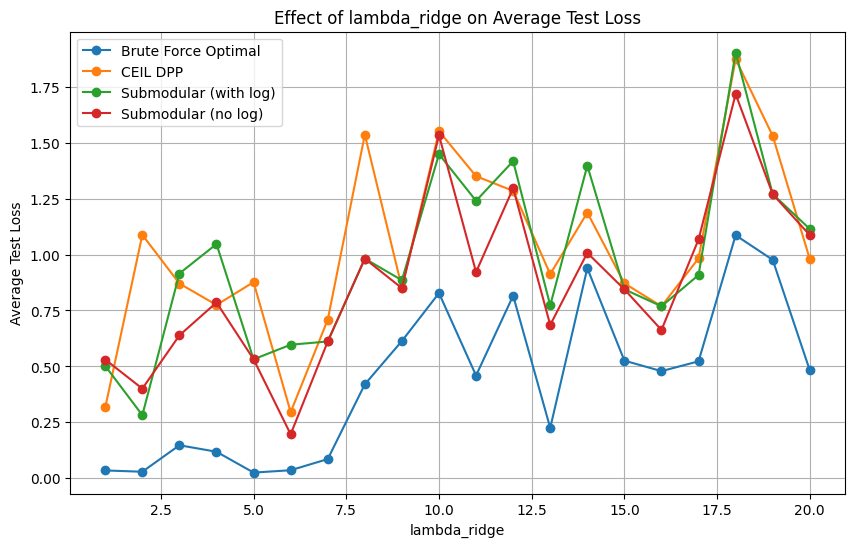

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# Fixed parameters
d = 5
N_train = 50
N_test = 50
K = 5
lambda_dpp_fixed = 1.0  # fixed
lambda_ridge_values = np.arange(1.0, 21.0, 1.0)

loss_optimal = []
loss_dpp = []
loss_submod_log = []
loss_submod_nolog = []

for lambda_ridge in tqdm(lambda_ridge_values, desc="Varying lambda_ridge"):
    results = experiment(d, N_train, N_test, K, lambda_ridge, lambda_dpp_fixed)
    loss_optimal.append(results["brute_force"]["loss"])
    loss_dpp.append(results["dpp"]["loss"])
    loss_submod_log.append(results["submodular_log"]["loss"])
    loss_submod_nolog.append(results["submodular_nolog"]["loss"])

plt.figure(figsize=(10,6))
plt.plot(lambda_ridge_values, loss_optimal, marker="o", label="Brute Force Optimal")
plt.plot(lambda_ridge_values, loss_dpp, marker="o", label="CEIL DPP")
plt.plot(lambda_ridge_values, loss_submod_log, marker="o", label="Submodular (with log)")
plt.plot(lambda_ridge_values, loss_submod_nolog, marker="o", label="Submodular (no log)")
plt.xlabel("lambda_ridge")
plt.ylabel("Average Test Loss")
plt.title("Effect of lambda_ridge on Average Test Loss")
plt.legend()
plt.grid(True)
plt.show()


Varying lambda_dpp:   0%|          | 0/20 [00:00<?, ?it/s]

Brute-force search over all subsets of size 5


Varying lambda_dpp:   5%|▌         | 1/20 [02:28<47:02, 148.56s/it]

Brute-force search over all subsets of size 5


Varying lambda_dpp:  10%|█         | 2/20 [04:54<44:07, 147.10s/it]

Brute-force search over all subsets of size 5


Varying lambda_dpp:  15%|█▌        | 3/20 [07:26<42:18, 149.33s/it]

Brute-force search over all subsets of size 5


Varying lambda_dpp:  20%|██        | 4/20 [10:00<40:21, 151.31s/it]

Brute-force search over all subsets of size 5


Varying lambda_dpp:  25%|██▌       | 5/20 [12:30<37:42, 150.82s/it]

Brute-force search over all subsets of size 5


Varying lambda_dpp:  30%|███       | 6/20 [15:07<35:38, 152.74s/it]

Brute-force search over all subsets of size 5


Varying lambda_dpp:  35%|███▌      | 7/20 [17:38<32:56, 152.06s/it]

Brute-force search over all subsets of size 5


Varying lambda_dpp:  40%|████      | 8/20 [20:05<30:08, 150.72s/it]

Brute-force search over all subsets of size 5


Varying lambda_dpp:  45%|████▌     | 9/20 [22:34<27:31, 150.11s/it]

Brute-force search over all subsets of size 5


Varying lambda_dpp:  50%|█████     | 10/20 [25:04<25:00, 150.01s/it]

Brute-force search over all subsets of size 5


Varying lambda_dpp:  55%|█████▌    | 11/20 [27:36<22:34, 150.52s/it]

Brute-force search over all subsets of size 5


Varying lambda_dpp:  60%|██████    | 12/20 [30:03<19:56, 149.62s/it]

Brute-force search over all subsets of size 5


Varying lambda_dpp:  65%|██████▌   | 13/20 [32:34<17:30, 150.06s/it]

Brute-force search over all subsets of size 5


Varying lambda_dpp:  70%|███████   | 14/20 [35:07<15:06, 151.00s/it]

Brute-force search over all subsets of size 5


Varying lambda_dpp:  75%|███████▌  | 15/20 [37:34<12:28, 149.77s/it]

Brute-force search over all subsets of size 5


Varying lambda_dpp:  80%|████████  | 16/20 [40:04<09:59, 149.84s/it]

Brute-force search over all subsets of size 5


Varying lambda_dpp:  85%|████████▌ | 17/20 [42:32<07:27, 149.14s/it]

Brute-force search over all subsets of size 5


Varying lambda_dpp:  90%|█████████ | 18/20 [45:04<04:59, 149.89s/it]

Brute-force search over all subsets of size 5


Varying lambda_dpp:  95%|█████████▌| 19/20 [47:35<02:30, 150.25s/it]

Brute-force search over all subsets of size 5


Varying lambda_dpp: 100%|██████████| 20/20 [50:04<00:00, 150.21s/it]


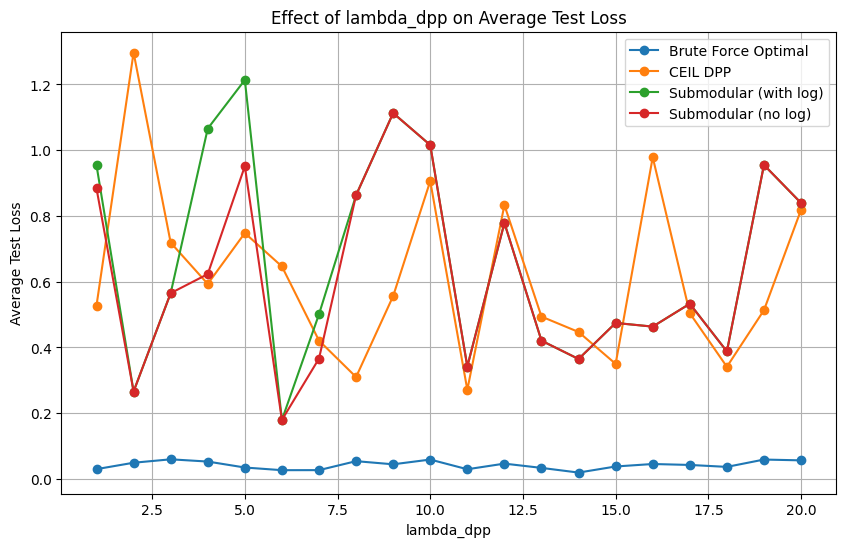

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# Fixed parameters
d = 5
N_train = 50
N_test = 50
K = 5
lambda_ridge_fixed = 1.0  # fixed
lambda_dpp_values = np.arange(1.0, 21.0, 1.0)

loss_optimal = []
loss_dpp = []
loss_submod_log = []
loss_submod_nolog = []

for lambda_dpp in tqdm(lambda_dpp_values, desc="Varying lambda_dpp"):
    results = experiment(d, N_train, N_test, K, lambda_ridge_fixed, lambda_dpp)
    loss_optimal.append(results["brute_force"]["loss"])
    loss_dpp.append(results["dpp"]["loss"])
    loss_submod_log.append(results["submodular_log"]["loss"])
    loss_submod_nolog.append(results["submodular_nolog"]["loss"])

plt.figure(figsize=(10,6))
plt.plot(lambda_dpp_values, loss_optimal, marker="o", label="Brute Force Optimal")
plt.plot(lambda_dpp_values, loss_dpp, marker="o", label="CEIL DPP")
plt.plot(lambda_dpp_values, loss_submod_log, marker="o", label="Submodular (with log)")
plt.plot(lambda_dpp_values, loss_submod_nolog, marker="o", label="Submodular (no log)")
plt.xlabel("lambda_dpp")
plt.ylabel("Average Test Loss")
plt.title("Effect of lambda_dpp on Average Test Loss")
plt.legend()
plt.grid(True)
plt.show()


Varying joint lambda:   0%|          | 0/20 [00:00<?, ?it/s]

Brute-force search over all subsets of size 5


Varying joint lambda:   5%|▌         | 1/20 [02:35<49:18, 155.72s/it]

Brute-force search over all subsets of size 5


Varying joint lambda:  10%|█         | 2/20 [05:03<45:21, 151.18s/it]

Brute-force search over all subsets of size 5


Varying joint lambda:  15%|█▌        | 3/20 [07:33<42:40, 150.64s/it]

Brute-force search over all subsets of size 5


Varying joint lambda:  20%|██        | 4/20 [10:02<39:59, 149.99s/it]

Brute-force search over all subsets of size 5


Varying joint lambda:  25%|██▌       | 5/20 [12:30<37:19, 149.33s/it]

Brute-force search over all subsets of size 5


Varying joint lambda:  30%|███       | 6/20 [15:00<34:51, 149.38s/it]

Brute-force search over all subsets of size 5


Varying joint lambda:  35%|███▌      | 7/20 [17:27<32:11, 148.57s/it]

Brute-force search over all subsets of size 5


Varying joint lambda:  40%|████      | 8/20 [19:54<29:36, 148.06s/it]

Brute-force search over all subsets of size 5


Varying joint lambda:  45%|████▌     | 9/20 [22:26<27:24, 149.48s/it]

Brute-force search over all subsets of size 5


Varying joint lambda:  50%|█████     | 10/20 [25:00<25:06, 150.69s/it]

Brute-force search over all subsets of size 5


Varying joint lambda:  55%|█████▌    | 11/20 [27:31<22:37, 150.87s/it]

Brute-force search over all subsets of size 5


Varying joint lambda:  60%|██████    | 12/20 [30:01<20:05, 150.69s/it]

Brute-force search over all subsets of size 5


Varying joint lambda:  65%|██████▌   | 13/20 [32:32<17:35, 150.76s/it]

Brute-force search over all subsets of size 5


Varying joint lambda:  70%|███████   | 14/20 [35:02<15:03, 150.58s/it]

Brute-force search over all subsets of size 5


Varying joint lambda:  75%|███████▌  | 15/20 [37:33<12:33, 150.63s/it]

Brute-force search over all subsets of size 5


Varying joint lambda:  80%|████████  | 16/20 [40:02<10:00, 150.01s/it]

Brute-force search over all subsets of size 5


Varying joint lambda:  85%|████████▌ | 17/20 [42:30<07:28, 149.42s/it]

Brute-force search over all subsets of size 5


Varying joint lambda:  90%|█████████ | 18/20 [44:58<04:58, 149.19s/it]

Brute-force search over all subsets of size 5


Varying joint lambda:  95%|█████████▌| 19/20 [47:27<02:29, 149.13s/it]

Brute-force search over all subsets of size 5


Varying joint lambda: 100%|██████████| 20/20 [49:54<00:00, 149.72s/it]


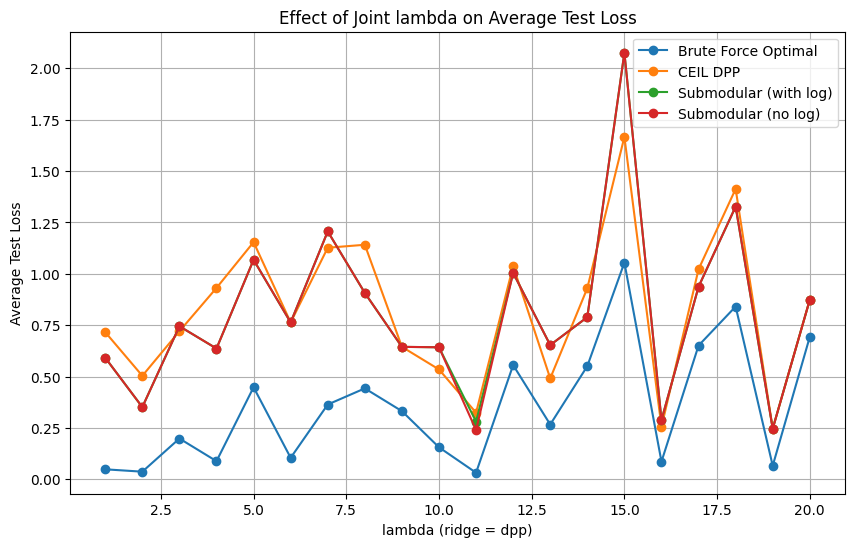

In [9]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# Fixed parameters
d = 5
N_train = 50
N_test = 50
K = 5
lambda_joint_values = np.arange(1.0, 21.0, 1.0)

loss_optimal = []
loss_dpp = []
loss_submod_log = []
loss_submod_nolog = []

for lam in tqdm(lambda_joint_values, desc="Varying joint lambda"):
    results = experiment(d, N_train, N_test, K, lam, lam)
    loss_optimal.append(results["brute_force"]["loss"])
    loss_dpp.append(results["dpp"]["loss"])
    loss_submod_log.append(results["submodular_log"]["loss"])
    loss_submod_nolog.append(results["submodular_nolog"]["loss"])

plt.figure(figsize=(10,6))
plt.plot(lambda_joint_values, loss_optimal, marker="o", label="Brute Force Optimal")
plt.plot(lambda_joint_values, loss_dpp, marker="o", label="CEIL DPP")
plt.plot(lambda_joint_values, loss_submod_log, marker="o", label="Submodular (with log)")
plt.plot(lambda_joint_values, loss_submod_nolog, marker="o", label="Submodular (no log)")
plt.xlabel("lambda (ridge = dpp)")
plt.ylabel("Average Test Loss")
plt.title("Effect of Joint lambda on Average Test Loss")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# Fixed hyperparameters
d = 5
N_train = 50
N_test = 50
lambda_ridge_fixed = 1.0
lambda_dpp_fixed = 1.0  # used in the np.exp(...) term

# Vary subset size k from 2 to 20 in steps of 2
k_values = np.arange(2, 21, 2)

loss_optimal = []       # Brute-force optimal loss
loss_dpp = []           # CEIL's DPP method loss
loss_submod_log = []    # Submodular method with log loss
loss_submod_nolog = []  # Submodular method without log loss

for k in tqdm(k_values, desc="Varying subset size k"):
    # Call the experiment function with current k and fixed parameters
    results = experiment(d, N_train, N_test, k, lambda_ridge_fixed, lambda_dpp_fixed)
    loss_optimal.append(results["brute_force"]["loss"])
    loss_dpp.append(results["dpp"]["loss"])
    loss_submod_log.append(results["submodular_log"]["loss"])
    loss_submod_nolog.append(results["submodular_nolog"]["loss"])

# Plot the average test loss versus subset size k
plt.figure(figsize=(10, 6))
plt.plot(k_values, loss_optimal, marker="o", label="Brute Force Optimal")
plt.plot(k_values, loss_dpp, marker="o", label="CEIL DPP")
plt.plot(k_values, loss_submod_log, marker="o", label="Submodular (with log)")
plt.plot(k_values, loss_submod_nolog, marker="o", label="Submodular (no log)")
plt.xlabel("Subset size k")
plt.ylabel("Average Test Loss")
plt.title("Effect of Subset Size (k) on Average Test Loss")
plt.legend()
plt.grid(True)
plt.show()

Varying subset size k:   0%|          | 0/10 [00:00<?, ?it/s]

Brute-force search over all subsets of size 2
Brute-force search over all subsets of size 4


Varying subset size k:  20%|██        | 2/10 [00:13<00:52,  6.56s/it]

Brute-force search over all subsets of size 6


Varying subset size k:  30%|███       | 3/10 [14:21<41:40, 357.27s/it]

Brute-force search over all subsets of size 8
